In [465]:
# Import necessary imports.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

config = {'font.family': 'serif', 'font.serif': ['Times New Roman']}
plt.rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False

In [466]:
df = pd.read_csv('./Dataset/Concrete Compressive Strength.csv')
df.shape

(1030, 9)

#### 相关性与相关显著性

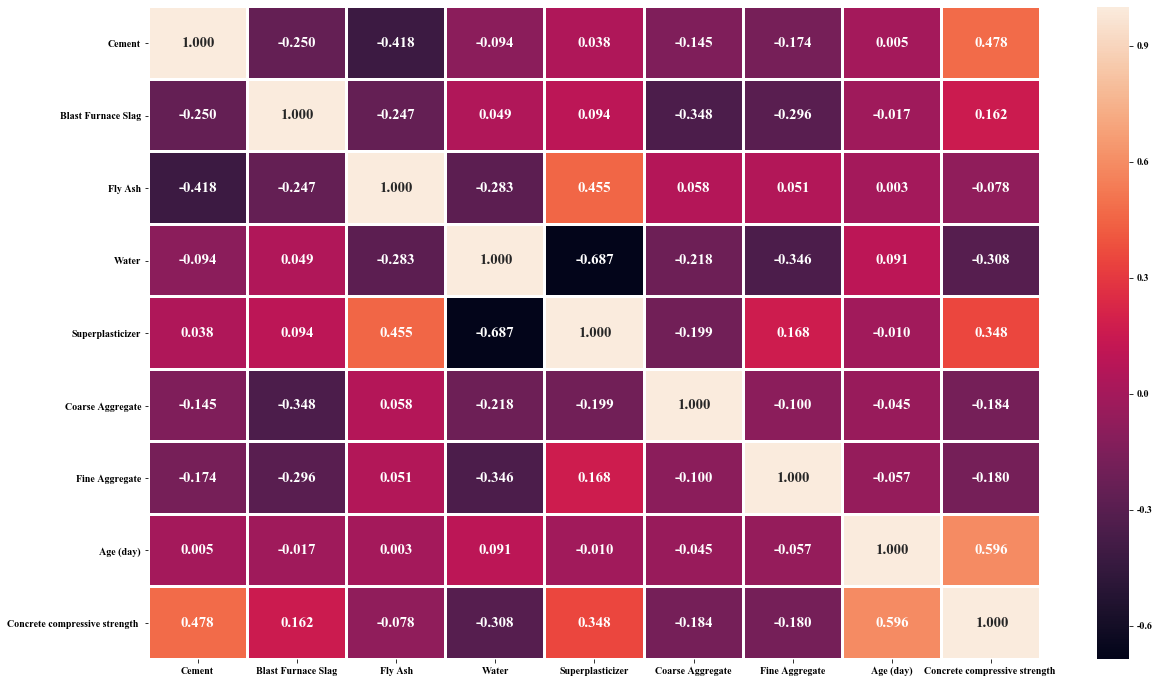

In [467]:
plt.figure(figsize = (20, 12))
# df.corr() method: Literal['pearson', 'kendall', 'spearman']
sns.heatmap(df.corr(method='spearman'), annot = True, fmt = '0.3f', annot_kws = {'size' : 15}, linewidth = 2, linecolor = 'white')
plt.show()

进一步打印出个特征变量与目标变量之间相关性系数，以及相关系数是否显著的P值.

In [468]:
# 此处参考了https://github.com/kfs196项目.
df_spearman = pd.DataFrame(columns=df.columns, index=['Spearman_r','Spearman_p'])
# 分别计算每个特征与目标变量之间的相关性.

for item in df.columns:
    spearman_r, spearman_p = stats.spearmanr(df[item], df['Concrete compressive strength '])
    df_spearman[item]['Spearman_r'] = np.round(spearman_r, 3)
    df_spearman[item]['Spearman_p'] = np.round(spearman_p, 3)

df_spearman

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
Spearman_r,0.478,0.162,-0.078,-0.308,0.348,-0.184,-0.18,0.596,1.0
Spearman_p,0.0,0.0,0.012,0.0,0.0,0.0,0.0,0.0,0.0


上述结果中，可以看到Cement、Superlasticizer以及Age与Concrete compressive strength之间存在较高线性关系。
p值用于检验相关系数的统计显著性，通常如果p值小于0.05，则认为相关性是显著的。

In [469]:
# distinguish feature and label.
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [470]:
# for column in X.columns:
#     X[column] += 1
#     X[column] = np.log(X[column])

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

In [472]:
# 特征标准化.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 

In [473]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(depth=6, iterations= 500, l2_leaf_reg= 3, learning_rate= 0.1)
cat_model.fit(X_train, y_train)

0:	learn: 15.8157852	total: 5.51ms	remaining: 2.75s
1:	learn: 14.9943797	total: 7.05ms	remaining: 1.75s
2:	learn: 14.2165182	total: 8.7ms	remaining: 1.44s
3:	learn: 13.4004705	total: 9.88ms	remaining: 1.22s
4:	learn: 12.7019511	total: 18.4ms	remaining: 1.82s
5:	learn: 12.0089864	total: 19.9ms	remaining: 1.64s
6:	learn: 11.4087878	total: 24.4ms	remaining: 1.72s
7:	learn: 10.8806148	total: 25.9ms	remaining: 1.59s
8:	learn: 10.4365578	total: 27.3ms	remaining: 1.49s
9:	learn: 9.9779914	total: 28.8ms	remaining: 1.41s
10:	learn: 9.5264134	total: 30.1ms	remaining: 1.34s
11:	learn: 9.1819069	total: 31.3ms	remaining: 1.27s
12:	learn: 8.8643135	total: 33.7ms	remaining: 1.26s
13:	learn: 8.5187470	total: 35.1ms	remaining: 1.22s
14:	learn: 8.2195726	total: 36.2ms	remaining: 1.17s
15:	learn: 7.9621051	total: 37.8ms	remaining: 1.14s
16:	learn: 7.7019182	total: 39.2ms	remaining: 1.11s
17:	learn: 7.4581119	total: 40.4ms	remaining: 1.08s
18:	learn: 7.2560726	total: 41.6ms	remaining: 1.05s
19:	learn: 7.0

In [474]:
# log 之前：0.9888853298098592 0.9436559682218028
# log 之后：0.9915293516791972 0.94644297488704
# iter600: 0.992932813968899 0.9478935844054335
print(cat_model.score(X_train, y_train), cat_model.score(X_test, y_test))

0.9915293516791972 0.9465652613074529


#### 模型拟合效果

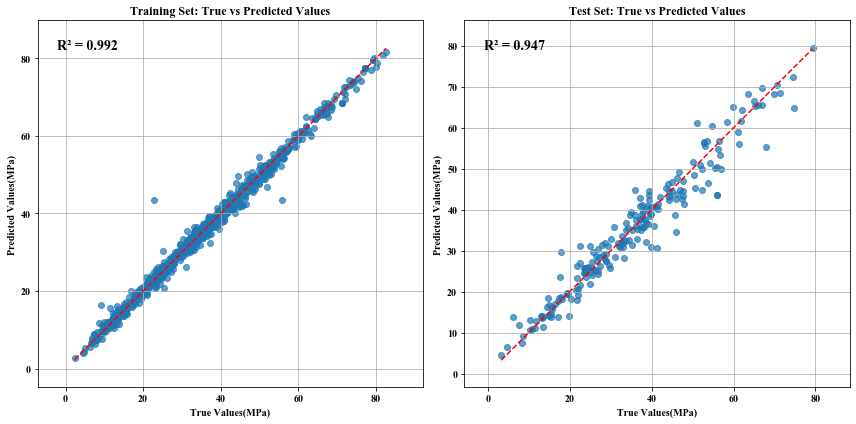

In [475]:
from sklearn.metrics import r2_score

# 获取预测值
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

# 计算 R² 值
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# 创建散点图
plt.figure(figsize=(12, 6))

# 绘制训练集
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r')  # 参考线
plt.title('Training Set: True vs Predicted Values')
plt.xlabel('True Values(MPa)')
plt.ylabel('Predicted Values(MPa)')
plt.axis('equal')  # 使坐标轴比例相同
plt.grid(True)
plt.text(0.05, 0.95, f'R² = {r2_train:.3f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')

# 绘制测试集
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # 参考线
plt.title('Test Set: True vs Predicted Values')
plt.xlabel('True Values(MPa)')
plt.ylabel('Predicted Values(MPa)')
plt.axis('equal')  # 使坐标轴比例相同
plt.text(0.05, 0.95, f'R² = {r2_test:.3f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.grid(True)
plt.tight_layout()  # 自动调整布局
plt.show()

In [476]:
X.columns

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age (day)'],
      dtype='object')

In [477]:
feature_importance = cat_model.get_feature_importance()
print(feature_importance)

# feature_names = cat_model.feature_names_
feature_names = X.columns
print(feature_names)

[22.82325074  8.88534939  1.65150661 14.2436602   6.94930916  3.49448191
  5.15174772 36.80069427]
Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age (day)'],
      dtype='object')


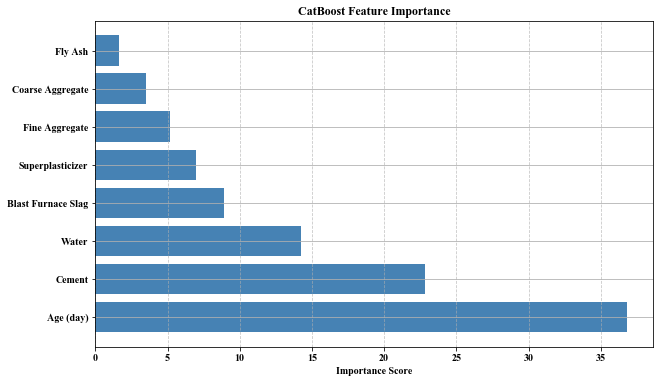

In [478]:
importance_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': feature_importance
})

# 按重要性排序
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.title('CatBoost Feature Importance')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

从上图可以看出，除养护期Age之外，Cement和Water是最重要的两个特征.

#### 抗压强度随养护时间的变化规律

In [479]:
# 此处参考了https://github.com/kfs196项目.
# https://nbviewer.org/github/kfs196/SimpleMLDemo-Concrete/blob/main/FinalReport2.ipynb
df['Cement'].value_counts()

425.00    20
362.60    20
251.37    15
446.00    14
310.00    14
          ..
451.00     1
151.60     1
133.10     1
145.90     1
260.90     1
Name: Cement, Length: 280, dtype: int64

In [480]:
df['Water'].value_counts()

192.0    118
228.0     54
185.7     46
203.5     36
186.0     28
        ... 
195.4      1
158.1      1
211.5      1
175.8      1
200.6      1
Name: Water, Length: 205, dtype: int64

In [481]:
# 根据最终要的特征"Cement", 选出出现频率最高的配合比.
df_cement = df[df['Cement'] == 425]
df_cement

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
72,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
73,425.0,106.3,0.0,151.4,18.6,936.0,803.7,3,36.300911
77,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
80,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
95,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.201007
96,425.0,106.3,0.0,151.4,18.6,936.0,803.7,7,46.801631
100,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.201007
103,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.201007
118,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.294676
119,425.0,106.3,0.0,151.4,18.6,936.0,803.7,28,61.797734


##### 第一种配合比

In [482]:
# 进一步结合"Water", 在df_cement中选出出现频率最高的配合比.
df_cement_water = df_cement[df_cement['Water'] == 153.5]
df_cement_water

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
72,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
77,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
80,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217
95,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.201007
100,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.201007
103,425.0,106.3,0.0,153.5,16.5,852.1,887.1,7,49.201007
118,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.294676
123,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.294676
126,425.0,106.3,0.0,153.5,16.5,852.1,887.1,28,60.294676
141,425.0,106.3,0.0,153.5,16.5,852.1,887.1,56,64.300532


In [483]:
selected1_index = [72,95,118,141,164]

##### 第二种配合比

In [484]:
# 这一种配合比中的Water取值均为164.9.
df_cement_1 = df[df['Cement'] == 362.60]
df_cement_1

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
83,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171
86,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171
91,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171
106,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.895819
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.895819
111,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.895819
114,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,22.897498
129,362.6,189.0,0.0,164.9,11.6,944.7,755.8,28,71.298713
132,362.6,189.0,0.0,164.9,11.6,944.7,755.8,28,71.298713


In [485]:
selected2_index = [83,106,129,152,175]

##### 第三种配合比

In [486]:
df_cement_2 = df[(df['Cement'] == 251.37)  & (df['Superplasticizer'] == 5.75)]
df_cement_2

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
274,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,3,17.223110
275,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,14,29.930153
276,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,28,29.654363
277,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,56,36.969703
278,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,100,43.581778
418,251.37,0.0,118.27,192.94,5.75,1043.6,754.30,3,11.983093
431,251.37,0.0,118.27,192.94,5.75,1043.6,754.30,14,20.725649
444,251.37,0.0,118.27,192.94,5.75,1043.6,754.30,28,33.274112
457,251.37,0.0,118.27,192.94,5.75,1043.6,754.30,56,39.265658
470,251.37,0.0,118.27,192.94,5.75,1043.6,754.30,100,40.148187


In [487]:
selected3_index = [418,431,444,457,470]

##### 第四种配合比

In [488]:
df_cement_3 = df[(df['Cement'] == 446) & (df['Superplasticizer'] == 11.64)]
# df_cement_3 = df[(df['Cement'] == 446)]
df_cement_3

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
472,446.0,24.0,79.0,162.0,11.64,967.0,712.0,28,44.422939
473,446.0,24.0,79.0,162.0,11.64,967.0,712.0,28,51.021224
476,446.0,24.0,79.0,162.0,11.64,967.0,712.0,3,25.021084
477,446.0,24.0,79.0,162.0,11.64,967.0,712.0,3,23.345657
479,446.0,24.0,79.0,162.0,11.64,967.0,712.0,7,38.017707
480,446.0,24.0,79.0,162.0,11.64,967.0,712.0,7,39.300132
482,446.0,24.0,79.0,162.0,11.64,967.0,712.0,56,56.144031
483,446.0,24.0,79.0,162.0,11.64,967.0,712.0,56,55.254607


In [489]:
selected4_index = [476,479, 482]

#### 利用上述4中配合比来预测强度

In [490]:
# 其中，将养护期Age取值设置为1-365, 这时候对应四个测试数据集如下：
# 行复制， Age取值为1-365.

# Mix1: 
df_cement_water.head(1)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
72,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3,33.398217


In [491]:
# Mix1-数据集构造.
testlist = df_cement_water.head(1)
np.array(testlist.iloc[:, :8])      # array([[425. , 106.3,   0. , 153.5,  16.5, 852.1, 887.1,   3. ]]).

# 重复365次.
df_repeated = pd.concat([testlist] * 365, ignore_index=True)
df_Mix1 = df_repeated.iloc[:, :8]

# 将Age填充为1-365.
df_Mix1['Age (day)'] = range(1, 366)
df_Mix1

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day)
0,425.0,106.3,0.0,153.5,16.5,852.1,887.1,1
1,425.0,106.3,0.0,153.5,16.5,852.1,887.1,2
2,425.0,106.3,0.0,153.5,16.5,852.1,887.1,3
3,425.0,106.3,0.0,153.5,16.5,852.1,887.1,4
4,425.0,106.3,0.0,153.5,16.5,852.1,887.1,5
...,...,...,...,...,...,...,...,...
360,425.0,106.3,0.0,153.5,16.5,852.1,887.1,361
361,425.0,106.3,0.0,153.5,16.5,852.1,887.1,362
362,425.0,106.3,0.0,153.5,16.5,852.1,887.1,363
363,425.0,106.3,0.0,153.5,16.5,852.1,887.1,364


In [492]:
# Mix2:
df_cement_1.head(1)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
83,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.301171


In [493]:
# Mix2-数据集构造.
def construct_repeated_dataset(input_df, num_repeats):
    """
    构造一个重复的 DataFrame，并将 Age 列填充为 1 到 num_repeats 的值。

    参数:
    input_df : pandas.DataFrame
        输入的 DataFrame。
    num_repeats : int
        要重复的行数。

    返回:
    pandas.DataFrame
        构造后的 DataFrame。
    """
    # 选择第一行
    testlist = input_df.head(1)

    # 重复 num_repeats 次
    df_repeated = pd.concat([testlist] * num_repeats, ignore_index=True)

    # 只保留前 8 列
    df_repeated = df_repeated.iloc[:, :8]

    # 将 Age (day) 列填充为 1 到 num_repeats
    df_repeated['Age (day)'] = range(1, num_repeats + 1)

    return df_repeated

# 调用构造函数，重复 365 次
df_Mix2 = construct_repeated_dataset(df_cement_1, 365)

df_Mix2

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day)
0,362.6,189.0,0.0,164.9,11.6,944.7,755.8,1
1,362.6,189.0,0.0,164.9,11.6,944.7,755.8,2
2,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3
3,362.6,189.0,0.0,164.9,11.6,944.7,755.8,4
4,362.6,189.0,0.0,164.9,11.6,944.7,755.8,5
...,...,...,...,...,...,...,...,...
360,362.6,189.0,0.0,164.9,11.6,944.7,755.8,361
361,362.6,189.0,0.0,164.9,11.6,944.7,755.8,362
362,362.6,189.0,0.0,164.9,11.6,944.7,755.8,363
363,362.6,189.0,0.0,164.9,11.6,944.7,755.8,364


In [494]:
# Mix3:
df_cement_2.head(1)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
274,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,3,17.22311


In [495]:
# Mix3-数据集构造.
def construct_repeated_dataset(input_df, num_repeats):
    testlist = input_df.head(1)
    df_repeated = pd.concat([testlist] * num_repeats, ignore_index=True)
    df_repeated = df_repeated.iloc[:, :8]
    df_repeated['Age (day)'] = range(1, num_repeats + 1)
    return df_repeated

df_Mix3 = construct_repeated_dataset(df_cement_2, 365)
df_Mix3

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day)
0,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,1
1,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,2
2,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,3
3,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,4
4,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,5
...,...,...,...,...,...,...,...,...
360,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,361
361,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,362
362,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,363
363,251.37,0.0,118.27,188.45,5.75,1028.4,757.73,364


In [496]:
# Mix4:
df_cement_3.head(1)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day),Concrete compressive strength
472,446.0,24.0,79.0,162.0,11.64,967.0,712.0,28,44.422939


In [497]:
# Mix3-数据集构造.
def construct_repeated_dataset(input_df, num_repeats):
    testlist = input_df.head(1)
    df_repeated = pd.concat([testlist] * num_repeats, ignore_index=True)
    df_repeated = df_repeated.iloc[:, :8]
    df_repeated['Age (day)'] = range(1, num_repeats + 1)
    return df_repeated

df_Mix4 = construct_repeated_dataset(df_cement_3, 365)
df_Mix4

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age (day)
0,446.0,24.0,79.0,162.0,11.64,967.0,712.0,1
1,446.0,24.0,79.0,162.0,11.64,967.0,712.0,2
2,446.0,24.0,79.0,162.0,11.64,967.0,712.0,3
3,446.0,24.0,79.0,162.0,11.64,967.0,712.0,4
4,446.0,24.0,79.0,162.0,11.64,967.0,712.0,5
...,...,...,...,...,...,...,...,...
360,446.0,24.0,79.0,162.0,11.64,967.0,712.0,361
361,446.0,24.0,79.0,162.0,11.64,967.0,712.0,362
362,446.0,24.0,79.0,162.0,11.64,967.0,712.0,363
363,446.0,24.0,79.0,162.0,11.64,967.0,712.0,364


##### 预测1-Mix1

In [498]:
# 4中配合比的预测结果.
cat_model = cat_model.fit(X, y)
y_test_pred_Mix1 = cat_model.predict(np.array(df_Mix1))
y_test_pred_Mix2 = cat_model.predict(np.array(df_Mix2))
y_test_pred_Mix3 = cat_model.predict(np.array(df_Mix3))
y_test_pred_Mix4 = cat_model.predict(np.array(df_Mix4))

0:	learn: 15.7245908	total: 1.72ms	remaining: 856ms
1:	learn: 14.8111881	total: 3.23ms	remaining: 804ms
2:	learn: 14.0998382	total: 4.64ms	remaining: 768ms
3:	learn: 13.3128660	total: 5.83ms	remaining: 722ms
4:	learn: 12.6456434	total: 7.08ms	remaining: 701ms
5:	learn: 11.9299626	total: 8.66ms	remaining: 713ms
6:	learn: 11.2985613	total: 10.3ms	remaining: 723ms
7:	learn: 10.7771010	total: 11.8ms	remaining: 727ms
8:	learn: 10.2868907	total: 13.2ms	remaining: 722ms
9:	learn: 9.8188095	total: 14.4ms	remaining: 705ms
10:	learn: 9.3915789	total: 15.6ms	remaining: 692ms
11:	learn: 9.0195371	total: 16.7ms	remaining: 680ms
12:	learn: 8.6598217	total: 17.9ms	remaining: 670ms
13:	learn: 8.3604270	total: 19ms	remaining: 661ms
14:	learn: 8.0944620	total: 20.2ms	remaining: 652ms
15:	learn: 7.8812741	total: 21.3ms	remaining: 645ms
16:	learn: 7.6737997	total: 22.7ms	remaining: 645ms
17:	learn: 7.4523984	total: 24.1ms	remaining: 647ms
18:	learn: 7.2257205	total: 25.4ms	remaining: 644ms
19:	learn: 7.02

In [499]:
df.columns

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age (day)',
       'Concrete compressive strength '],
      dtype='object')

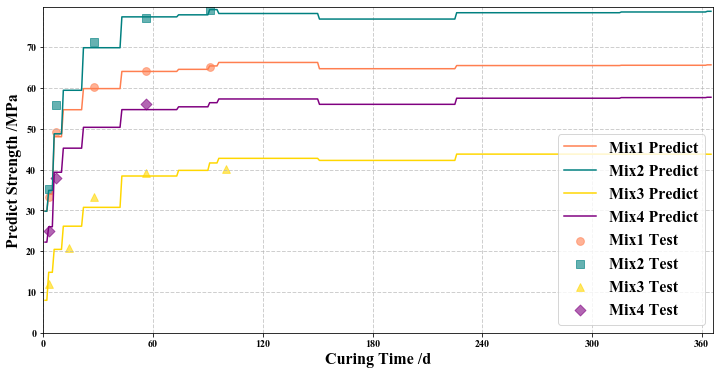

In [500]:
# 创建绘图
fig = plt.figure(figsize=(12, 6))

# 绘制预测结果
plt.plot(np.arange(1, 366, 1), y_test_pred_Mix1, color='coral', linewidth=1.5, label='Mix1 Predict')
plt.plot(np.arange(1, 366, 1), y_test_pred_Mix2, color='teal', linewidth=1.5, label='Mix2 Predict')
plt.plot(np.arange(1, 366, 1), y_test_pred_Mix3, color='gold', linewidth=1.5, label='Mix3 Predict')  # 不同颜色
plt.plot(np.arange(1, 366, 1), y_test_pred_Mix4, color='purple', linewidth=1.5, label='Mix4 Predict')  # 不同颜色

# 绘制实测数据散点
mix1_age = np.array([df['Age (day)'][i] for i in selected1_index]) 
mix1_strength = np.array([df['Concrete compressive strength '][i] for i in selected1_index])   

mix2_age = np.array([df['Age (day)'][i] for i in selected2_index])  
mix2_strength = np.array([df['Concrete compressive strength '][i] for i in selected2_index]) 

mix3_age = np.array([df['Age (day)'][i] for i in selected3_index])  
mix3_strength = np.array([df['Concrete compressive strength '][i] for i in selected3_index])

mix4_age = np.array([df['Age (day)'][i] for i in selected4_index])  
mix4_strength = np.array([df['Concrete compressive strength '][i] for i in selected4_index])

# 散点绘制（不同颜色和不同形状）
plt.scatter(mix1_age, mix1_strength, color='coral', alpha=0.6, marker='o', s=60, label='Mix1 Test')  # 圆形
plt.scatter(mix2_age, mix2_strength, color='teal', alpha=0.6, marker='s', s=60, label='Mix2 Test')   # 正方形
plt.scatter(mix3_age, mix3_strength, color='gold', alpha=0.6, marker='^', s=60, label='Mix3 Test')   # 三角形
plt.scatter(mix4_age, mix4_strength, color='purple', alpha=0.6, marker='D', s=60, label='Mix4 Test')  # 菱形

# 添加标签和图例
plt.legend(fontsize=16)
plt.xlabel('Curing Time /d', fontsize=16)
plt.ylabel('Predict Strength /MPa', fontsize=16)
plt.grid(linestyle='--', linewidth=1, alpha=0.6)
plt.xticks(np.arange(0, 366, 60))
plt.yticks(np.arange(0, 80, 10))
plt.xlim(0, 366)
plt.ylim(0,80)
plt.show()


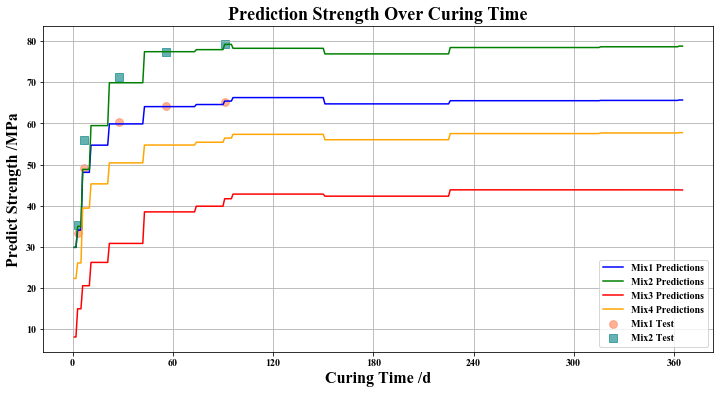

In [501]:
x = np.arange(1, 366)  # 1 到 365.

plt.figure(figsize=(12, 6))
plt.plot(x, y_test_pred_Mix1, label='Mix1 Predictions', color='blue')
plt.plot(x, y_test_pred_Mix2, label='Mix2 Predictions', color='green')
plt.plot(x, y_test_pred_Mix3, label='Mix3 Predictions', color='red')
plt.plot(x, y_test_pred_Mix4, label='Mix4 Predictions', color='orange')


mix1_age = np.array([df['Age (day)'][i] for i in selected1_index]) 
mix1_strength = np.array([df['Concrete compressive strength '][i] for i in selected1_index])   

mix2_age = np.array([df['Age (day)'][i] for i in selected2_index])  
mix2_strength = np.array([df['Concrete compressive strength '][i] for i in selected2_index]) 


plt.scatter(mix1_age, mix1_strength, color='coral', alpha=0.6, marker='o', s=60, label='Mix1 Test')  # 圆形
plt.scatter(mix2_age, mix2_strength, color='teal', alpha=0.6, marker='s', s=60, label='Mix2 Test')   # 正方形

plt.xlabel('Curing Time /d', fontsize=16)
plt.ylabel('Predict Strength /MPa', fontsize=16)
plt.xticks(np.arange(0, 366, step=60))
plt.legend()
plt.grid(True)
plt.title('Prediction Strength Over Curing Time', fontsize=18)
plt.show()